# Self Supervised Learning - Test 8
* Here we will be implementing the SimCLR architecture for self supervised learning
* SimCLR, or Contrastive Learning for Self-Supervised Learning, is a popular self-supervised learning technique for deep neural networks. It is a form of unsupervised learning where a model learns to identify similarities and differences between different views of the same data. The goal of SimCLR is to learn good representations of data that can be used for downstream tasks, such as image classification and object detection. SimCLR does this by training a deep neural network to maximize the similarity between two augmented views of the same image, while minimizing the similarity between views of different images. This is done using a contrastive loss function. SimCLR has been shown to achieve state-of-the-art results on several image classification benchmarks, often with significantly fewer labeled examples than supervised methods. 
* The idea here is to
    * Train the transformer in self supervised fashion
    * Use the trained weights of the transformer
    * Freeze those weights, add an additional mlp layer, and train on downstream tasks, like here, for classification
    * Note that I'm freezing the weights here to show that the transformer learns meaningful representations about the images already wehn trained in a self supervised fashsion
        * We simply will be using those frozen weights to generate features which will be passed through an MLP to clasify
        
**NOTE**: Code snippets from https://theaisummer.com/simclr/#the-simclr-method-contrastive-learning have been used 

**NOTE**: The self-supervised learning has been trained for **75 epochs and the downstream for 25 epochs** because of time and GPU contstraints. Training for longer with bigger models in the project would be very useful

## Define some downloads

In [3]:
!pip install pytorch-lightning
!pip install lightning-bolts
!pip install python-box
!pip install lightning-flash

## Define Imports

In [25]:
import torch
import torchvision.models as models
import numpy as np
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import GradientAccumulationScheduler
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import pytorch_lightning as pl
import torch.optim as optim
import timm
from box import Box
from flash.core.optimizers import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Define the configuration

In [5]:
config = {
    "model": "vit_tiny_patch16_224",
    "epochs": 75,
    "seed": 42,
    "grad_accumulation_steps": 6,
    "batch_size": 4,
    "lr": 3e-4,
    "weight_decay": 1e-6,
    "emb_size": 128,
    "temp": 0.5,
    "optimizer": "Adam",
    "size": 128,
    "img_size": 224,
}

config = Box(config)

# Training the SimCLR model
* Use pytorch lightning to control the training step and use custom loss
* Train for jusy 75 epochs as a trail 
* Using a very small Vision transformer as my current hardware cannot support bigger architecture
* Grad accumulation has been used to emulate larger batch sizes

## Define loss function
* The ContrastiveLoss class implements the contrastive loss function used in SimCLR, which is a type of unsupervised learning objective for learning representations from unlabeled data. The idea is to encourage similar representations for two different views of the same input and dissimilar representations for different inputs.
* The class computes the similarity between pairs of representations (z_i, z_j) using cosine similarity, and applies a temperature scaling factor to make the similarity scores smooth. The loss is calculated using a softmax function that compares the similarity score of positive pairs with the similarity score of all negative pairs. Finally, the loss is computed as the negative log-likelihood of the softmax probabilities.

In [6]:
def device_as(t1, t2):
    """
    Moves t1 to the device of t2
    """
    return t1.to(t2.device)

class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

    def calc_similarity_batch(self, a, b):
        representations = torch.cat([a, b], dim=0)
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

## Define Model

In [7]:
class SimCLR(nn.Module):
    def __init__(self, model_name = 'swin_base_patch4_window12_384',  projection_dim=128):
        super(SimCLR, self).__init__()

        # define the Swin Transformer backbone
        self.backbone = timm.create_model(model_name, pretrained=True)

        # modify the backbone to remove the classification head
        num_features = self.backbone.head.in_features
        self.backbone.head = nn.Identity()

        # add a projection head to the backbone
        self.projection_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        # apply the backbone to the input
        x = self.backbone(x)

        # apply the projection head to the output of the backbone
        x = self.projection_head(x)

        return x

In [8]:
def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups

## Define PL module to train 

In [9]:
import random
class SimCLRModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # define the SimCLR model
        self.model = SimCLR(config.model)

        # define the contrastive loss criterion
        self.criterion = ContrastiveLoss(self.config.batch_size, temperature=self.config.temp)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x1, x2 = batch

        # compute the projections of the two views of the input
        proj_1 = self(x1)
        proj_2 = self(x2)

        # compute the contrastive loss
        loss = self.criterion(proj_1, proj_2)

        self.log('train_loss', loss,prog_bar=True, on_epoch=True)

        return loss

    def configure_optimizers(self):
        max_epochs = config.epochs
        param_groups = define_param_groups(self.model, self.config.lr, 'adam')
        lr = 3e-4
        optimizer = Adam(param_groups, lr=self.config.lr, weight_decay=self.config.weight_decay)

        scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,
                                                         warmup_start_lr=0.0)

        return [optimizer], [scheduler_warmup]

## Define Augmentations and Dataset classes for SimCLR
* Here we define the augmentations that create two different variations of the same image
* We then push them model to learn representations such that these varaiations are considered the same image

In [ ]:
class SimCLRAugmentation(object):
    def __init__(self, size=224):
        self.size = size

        self.color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.augment = transforms.Compose([
            transforms.RandomResizedCrop(size=self.size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.RandomApply([self.color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            self.normalize
        ])

    def __call__(self, x):
        x1 = self.augment(x)
        x2 = self.augment(x)
        return x1, x2

In [ ]:
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        self.resize = transforms.Resize((config.img_size, config.img_size))

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        image = self.resize(image)
        image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_paths)

## Get all data

In [ ]:
import glob
# GEt data paths
data = glob.glob("/notebooks/gsoc-prep-23/ml4sci/data/lenses/*/*")

# Define Augment
transform = SimCLRAugmentation(config.img_size)

# define the training dataset
train_dataset = SimCLRDataset(data, transform=transform)

# define the training data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    num_workers=8,
    pin_memory=True,
    shuffle=True
)

In [ ]:
# Sanity check
for x,y in train_loader:
    print(x.shape, y.shape)
    break

In [ ]:
import matplotlib.pyplot as plt
def show_simclr_images(dataloader):
    # Get a batch of images from the dataloader
    x1, x2 = next(iter(dataloader))
    
    # Extract the two augmented versions of each image
    # x1 = x[:, 0]
    # x2 = x[:, 1]
    
    # Concatenate the two images side by side
    concat_imgs = torch.cat([x1, x2], dim=3)
    
    # Convert the tensor to a numpy array and transpose the dimensions
    np_imgs = concat_imgs.permute(0, 2, 3, 1).numpy()
    
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5, 10))
    for i, np_img in enumerate(np_imgs):
        if i == 5:
            break
        axes[i].imshow(np_img)
        axes[i].axis('off')
        axes[i].set_title(f'Image pair {i+1}')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


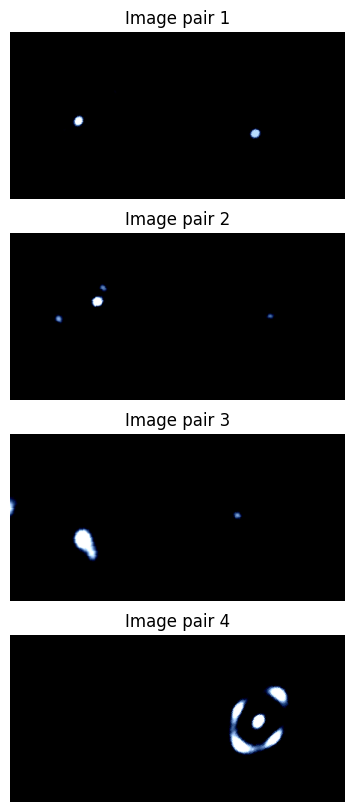

In [14]:
show_simclr_images(train_loader)

## Fit the mode
* Use grad accumulation to emulate big batches

In [19]:
model = SimCLRModule(config)

In [20]:
trainer = pl.Trainer(
    max_epochs=config.epochs,
    accumulate_grad_batches = config.grad_accumulation_steps,
    callbacks=[
        RichProgressBar(leave=True),
        ModelCheckpoint(dirpath='./models/', monitor="train_loss", mode="min"),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ SimCLR          │  5.7 M │
│ 1 │ criterion │ ContrastiveLoss │      0 │
└───┴───────────┴─────────────────┴────────┘

Trainable params: 5.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.7 M                                                                                                
Total estimated model params size (MB): 22

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=75` reached.


# Finetuning on classification
* Once we trained the backbone to understand 
* We shall use those weights to train on downstream tasks
* NOTE that the backbone weights are freezed during training on downstream tasks, This is to illustrate that the backbone has learnt a succesfuul way to represent the images after self supervised learning
* We shall be using fastai and code similar to task 5 to quickly prototype a classification model
    * Quick prototying is crucial in experimentation, and hence in research

In [17]:
from fastai.vision.all import *

## Get weights of only backbone for finetuning

In [50]:
# Get checkpoint
checkpoint = torch.load("/notebooks/gsoc-prep-23/ml4sci/notebooks/models/epoch=70-step=29607.ckpt")
# Init model
model = SimCLR(config.model)
model_weights = checkpoint["state_dict"]
# update keys by dropping `model`
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)
# Load weights into model
model.load_state_dict(model_weights)

<All keys matched successfully>

In [51]:
# Get the backbone
backbone = model.backbone

## Create a model with the backbone trained on self supervised learning

In [52]:
for param in backbone.parameters():
    param.requires_grad = False

model_ft = torch.nn.Sequential(
    backbone,
    torch.nn.Linear(backbone.num_features, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,1),
    torch.nn.Sigmoid()
    )

## Get data

In [53]:
# Get data
# Split data into train and test
categories = {
    "sub": 0,
    "no_sub": 1,
}

dataset_path = "/notebooks/gsoc-prep-23/ml4sci/data/lenses/"

# Get file paths as a list
all_files = glob.glob(dataset_path + "*/*")
all_labels = [x.split('/')[-2] for x in all_files]

print("Got files", len(all_files))

Got files 10000


In [54]:
# Dataset object
# Use albumentations for data augmentation
class SubstructureBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_files, transform=None):
        self.data_files = data_files
        self.transform = transform
    def __len__(self):
        return len(self.data_files)
    def __getitem__(self, idx):
        # Open as one channel
        image = np.array((Image.open(self.data_files[idx])).convert('RGB'))
        # Get label from path
        label = categories[self.data_files[idx].split("/")[-2]]
        # Apply transformations
        if self.transform:
            image = self.transform(image=image)["image"]
        # Convert to tensor
        label = torch.tensor([label], dtype=torch.float32)
        # Min max normalise
        image = (image - image.min() ) / ( image.max() - image.min())
        return image.to(torch.float32),label

In [55]:
# Split into 90-10
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42, stratify=all_labels)

In [56]:
# Define the augmentations
# Handles overfitting and facilitates better training
train_transform = A.Compose([
    A.Resize(config.img_size, config.img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.pytorch.transforms.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(config.img_size, config.img_size),
    A.pytorch.transforms.ToTensorV2()
])

train_dataset = SubstructureBinaryDataset(train_files, transform=train_transform)
val_dataset = SubstructureBinaryDataset(val_files, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

In [57]:
# Sanity check
b = next(iter(train_dataloader))
print(b[0][0].shape)
print(b[1][0].shape)

torch.Size([3, 224, 224])
torch.Size([1])


In [58]:
dls = DataLoaders(train_dataloader, val_dataloader)

In [59]:
learn = Learner(
    dls,
    model_ft,
    loss_func=BCELossFlat(),
    cbs=[
        SaveModelCallback(monitor='valid_loss'),
    ])

SuggestedLRs(valley=0.0002290867705596611)

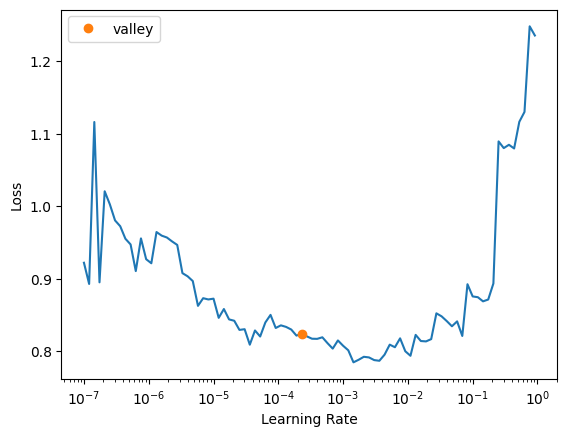

In [60]:
learn.lr_find()

In [61]:
learn.fit_one_cycle(25, 0.0002)

epoch,train_loss,valid_loss,time
0,0.666383,0.668117,00:40
1,0.640198,0.629249,00:41
2,0.560453,0.590474,00:41
3,0.538492,0.517427,00:42
4,0.539526,0.478486,00:43
5,0.466260,0.505412,00:42
6,0.452288,0.411889,00:42
7,0.443911,0.409228,00:43
8,0.455896,0.378895,00:44
9,0.399023,0.378912,00:43


Better model found at epoch 0 with valid_loss value: 0.6681167483329773.
Better model found at epoch 1 with valid_loss value: 0.629249095916748.
Better model found at epoch 2 with valid_loss value: 0.590474009513855.
Better model found at epoch 3 with valid_loss value: 0.517427384853363.
Better model found at epoch 4 with valid_loss value: 0.4784860908985138.
Better model found at epoch 6 with valid_loss value: 0.4118889272212982.
Better model found at epoch 7 with valid_loss value: 0.4092279076576233.
Better model found at epoch 8 with valid_loss value: 0.3788951337337494.
Better model found at epoch 12 with valid_loss value: 0.3611922264099121.
Better model found at epoch 13 with valid_loss value: 0.3363032639026642.
Better model found at epoch 14 with valid_loss value: 0.3359276354312897.
Better model found at epoch 15 with valid_loss value: 0.3213690519332886.
Better model found at epoch 16 with valid_loss value: 0.3190934956073761.
Better model found at epoch 17 with valid_loss va

In [62]:
import tqdm

model_ft.to('cuda')
model_ft.eval()
val_preds = []
val_targets = []
with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        x,y = batch
        x = x.to('cuda')
        outputs = model_ft(x)
        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(y.cpu().numpy())

100%|██████████| 250/250 [00:03<00:00, 70.96it/s]


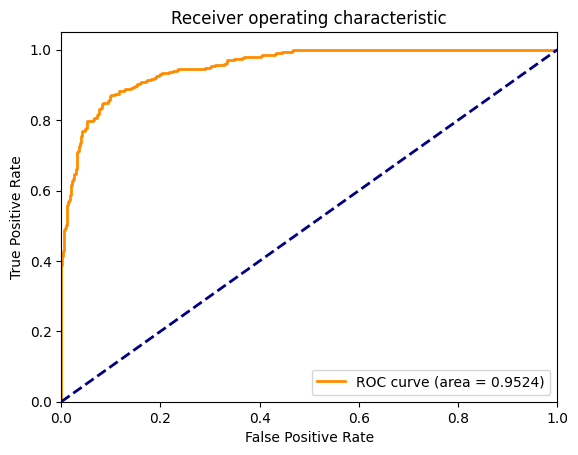

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have `val_targets`, `val_preds`, and `val_auc` variables for binary classification
fpr, tpr, thresholds = roc_curve(val_targets, val_preds)
roc_auc = roc_auc_score(val_targets, val_preds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
print("AUC scores", roc_auc)

AUC scores 0.95242
